In [123]:
import numpy as np
import os
import glob
from random import random
import torch
gestures = ['SwipeLeft', 'SwipeRight', 'RaiseHand', 'ClapHands', 'Push']
feature = 'spec'
base_dir = f'D:\\Google Drive\\PhD\\Spring 2023\\DL\\'


test_d_spec = []



train_d_spec = []

def convert_to_pytorch_input_id(input_data):
    id1 = np.array(input_data, copy=True)
    print(f'{id1.shape=}')
    id2 = np.expand_dims(id1, axis=3)
    return id2

gesture_count = 0
gestures_ctr = dict.fromkeys(gestures)
for gesture in gestures:
    gestures_ctr[gesture] = 0

for gesture in gestures:
    spec_str = os.path.join(base_dir,'segmented',gesture,'spec')
    spec_files = glob.glob(os.path.join(spec_str, f'spec_{gesture}_*.npy'))
    print(f'{len(spec_files)=}')
    if len(spec_files) > 0:
        for i in range(0,len(spec_files)):
            spec_data = np.load(spec_files[i])
            gesture_count = gesture_count + 1
            gestures_ctr[gesture] = gestures_ctr[gesture] + 1
            #adding one dimension (idk why)
            spec_data = np.expand_dims(spec_data, axis=0)     
            if random() < 0.6:
                train_d_spec.append((torch.tensor(spec_data),gestures.index(gesture)))
#                 train_d_spec.append(torch.tensor(spec_data))
#                 train_l.append(gesture)
            else:
                test_d_spec.append((torch.tensor(spec_data),gestures.index(gesture)))
                


print(f"{gesture_count=},{gestures_ctr=}")



len(spec_files)=51
len(spec_files)=48
len(spec_files)=50
len(spec_files)=51
len(spec_files)=50
gesture_count=250,gestures_ctr={'SwipeLeft': 51, 'SwipeRight': 48, 'RaiseHand': 50, 'ClapHands': 51, 'Push': 50}


In [124]:
import numpy as np
import os
import glob
from random import random
import torch
gestures = ['SwipeLeft', 'SwipeRight', 'RaiseHand', 'ClapHands', 'Push']
base_dir = f'G:\\My Drive\\PhD\\Spring 2023\\DL\\segmented'





class TrainDataset(torch.utils.data.Dataset):
    def __init__(self, train_d_spec):
        self.gesture_count = len(train_d_spec)
        self.train_d_spec = train_d_spec
        
    def __len__(self):
        return self.gesture_count 

    def __getitem__(self, index):
        # Select sample
        # Load data and get label
        X = self.train_d_spec[index][0]
        y = self.train_d_spec[index][1]
        return X, y
    
    
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, test_d_spec):
        self.gesture_count = len(test_d_spec)
        self.test_d_spec = test_d_spec
        
    def __len__(self):
        return self.gesture_count 

    def __getitem__(self, index):
        # Select sample
        # Load data and get label
        X = self.test_d_spec[index][0]
        y = self.test_d_spec[index][1]
        return X, y

# print(type(trainloader))

In [125]:
# %reset -f
import torch
import torch.nn as nn
import sys
import time
from typing import Union, List, Dict, Any, cast
from torch.nn import init
import torchvision
import torchvision.transforms as transforms
import numpy as np
import torch.nn.functional as F
from torch import optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# batch_size=15

# transform = transforms.Compose([transforms.Resize(224),transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])
# trainset = torchvision.datasets.MNIST(root="./data",train=True, transform=transform, download=True)
# testset = torchvision.datasets.MNIST(root="./data",train=False, transform=transform, download=True)
# trainloader = torch.utils.data.DataLoader(dataset=trainset,batch_size=batch_size,shuffle=True)
# testloader = torch.utils.data.DataLoader(dataset=testset,batch_size=batch_size,shuffle=False)

batch_size=250    
trainset = TrainDataset(train_d_spec)
testset = TestDataset(test_d_spec)
trainloader = torch.utils.data.DataLoader(dataset=trainset,batch_size=batch_size,shuffle=True)
testloader = torch.utils.data.DataLoader(dataset=testset,batch_size=batch_size,shuffle=False)



def vgg_block(num_convs, in_channels, num_channels):
    layers=[]
    for i in range(num_convs):
        layers+=[nn.Conv2d(in_channels=in_channels, out_channels=num_channels, kernel_size=3, padding=1, bias=False)]
        in_channels=num_channels
        #layers +=[nn.BatchNorm2d(num_channels)]
        layers +=[nn.ReLU(inplace=True)]
    layers +=[nn.MaxPool2d(kernel_size=2, stride=2)]
    return nn.Sequential(*layers)
 
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv_arch=((1,1,64),(1,64,128),(2,128,256),(2,256,512),(2,512,512))
        layers=[]
        for (num_convs,in_channels,num_channels) in self.conv_arch:
            layers+=[vgg_block(num_convs,in_channels,num_channels)]
        self.features=nn.Sequential(*layers)
        self.dense1 = nn.Linear(512*14,4096)
        self.drop1 = nn.Dropout(0.5)
        self.dense2 = nn.Linear(4096, 1000)
        self.drop2 = nn.Dropout(0.5)
        self.dense3 = nn.Linear(1000, 5)
        # self.dense4 = nn.Linear(10,10)
 
    def forward(self,x):
#         print(x.size())
        x=self.features(x)
#         print(x.size())
        x=x.view(-1,512*14)
        x=self.dense3(self.drop2(F.relu(self.dense2(self.drop1(F.relu(self.dense1(x)))))))
        return x

confusion = torch.zeros(len(gestures), len(gestures))

def evaluate_accuracy(data_iter, net, device=None):
    if device is None and isinstance(net, torch.nn.Module):
        # If device is not specified, use net device
        device = list(net.parameters())[0].device
    acc_sum, n = 0.0, 0
    with torch.no_grad():
        y_test = []
        y_pred = []
        for X, y in data_iter:
            if isinstance(net, torch.nn.Module):
                # Evaluation mode, turn off dropout
                net.eval()
                prediction = net(X.float().to(device)).argmax(dim=1)
                gt = y.to(device)
                y_pred.append(prediction.cpu().numpy())
                y_test.append(gt.cpu().numpy())
                
#                 for i in range(len(gt)):
#                     confusion[prediction[i]][gt[i]] += 1 
                acc_sum += (net(X.float().to(device)).argmax(dim=1) == y.to(device)).float().sum().cpu().item()
                # Change back to training mode
                net.train() 
            else:
                if ('is_training' in net.__code__.co_varnames):  # If there is a parameter of is_training
                    # Set is_training to False
                    acc_sum += (net(X, is_training=False).argmax(dim=1) == y).float().sum().item()
                else:
                    acc_sum += (net(X).argmax(dim=1) == y).float().sum().item()
            n += y.shape[0]
            # Normalize by dividing every row by its sum
            for i in range(len(gestures)):
                confusion[i] = confusion[i] / confusion[i].sum()
#             print(f'{confusion=}')
    return acc_sum / n, y_pred, y_test

def train(train_iter, test_iter, net, optimizer, device, num_epochs):
    # Deploy the network on the gpu device
#     print(type(train_iter))
    net = net.float()
    net = net.to(device)
    print("training on", device)
    # Cross entropy
    loss = torch.nn.CrossEntropyLoss()
    batch_count = 0
    collaps = 0
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        for  X, y in tqdm(train_iter):
            # Input attributes
            X = X.to(device)
            # Tags
            y = y.to(device)
            # Forecast
            y_hat = net(X.float())
            # Calculate loss
            l = loss(y_hat, y)
            # Gradient descent
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            
            train_l_sum += l.cpu().item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().cpu().item()
            n += y.shape[0]
            batch_count += 1

            
            
num_epochs = 200
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

net1 = Net()
optimizer = torch.optim.SGD(net1.parameters(), lr=0.003, momentum=0.3)
# print(type(trainloader))
# train_features, train_labels = next(iter(trainloader))

# for i in range(1,10):
#     print(trainset[i][0].size())
train(trainloader, testloader, net1, optimizer, device, num_epochs)
# Test set accuracy
test_acc, y_pred, y_test = evaluate_accuracy(testloader, net1)
print(test_acc)



cuda
training on cuda


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.99it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.88it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.02it/s]

0.9222222222222223


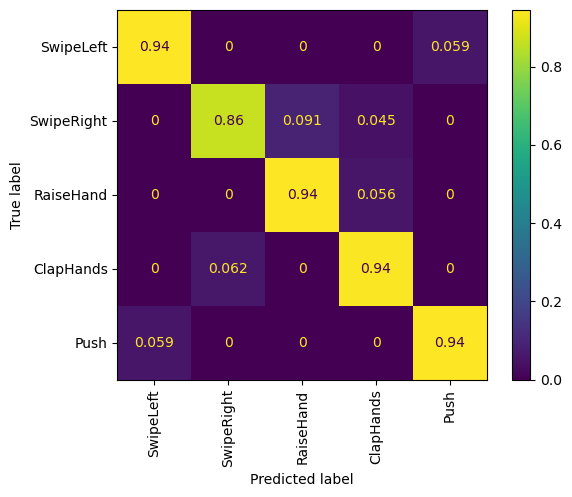

In [126]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_test_temp = np.array(y_test)[0]
y_pred_temp = np.array(y_pred)[0]

cm = confusion_matrix(y_test_temp,y_pred_temp,normalize='true')
ConfusionMatrixDisplay(cm,display_labels=gestures).plot(xticks_rotation='vertical')
# print(f'{prediction=},{gt=}')


In [127]:
plt.show()